In [1]:
# Mathematical calculation
import numpy as np

# Data handling
import pandas as pd

# Data Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

# Model Building, Designing and Validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, f1_score, auc, accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import zscore

In [2]:
#Read the Data File
bank_df = pd.read_csv("Bank_Personal_Loan_Modelling-1.csv", na_values=['NA','?','N/A','NAs','NAN','nan',''])

In [3]:
bank_df.head(2)

# Id is the Customer ID
# Age,Experience(proffesional) - In years
# Income - $000
# ZIP Code - Home Address
# Family - family size count
# CCAvg - Avg spending on credit cards per month in $000
# Education - 1: Undergrad; 2: Graduate; 3: Advanced/Professional
# Mortgage - House mortgage if any in $000
# Personal Loan- Loan accepted in last campaign. -- Target Column
# Securities Account - Customer hold any with bank - Boolean
# CD Account - customer have a certificate of deposit (CD) account with the bank. Boolean
# Online - customer use internet banking facilities? Boolean
# CreditCard - customer use a credit card issued by UniversalBank? Boolean

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0


In [4]:
#The entire data is of liability customers i.e., from the last campaign.
#Verifying few given details.

In [5]:
print("Customers who took personal loan: ",bank_df[bank_df['Personal Loan']==0].shape[0])
print("Customers who didn't take personal loan: ",bank_df[bank_df['Personal Loan']==1].shape[0])

Customers who took personal loan:  4520
Customers who didn't take personal loan:  480


In [6]:
print("Conversion rate of customers: ",(bank_df[bank_df['Personal Loan']==1].shape[0]/bank_df.shape[0])*100,"%")

Conversion rate of customers:  9.6 %


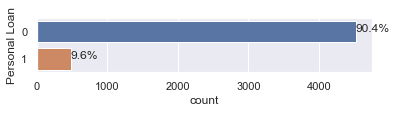

In [7]:
#Visualizing Personal Loan value count
ax = sns.set(rc={'figure.figsize':(6,1)})
ax = sns.countplot(y='Personal Loan', data=bank_df)
total = len(bank_df['Personal Loan'])

# Adding percentage to the horizontal bars
for p in ax.patches:
    percentage = '{:.1f}%'.format(100*p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))
plt.show()

# From the below count plot, we can see that 90% of the customers haven't opeted for loans whereas 9.6% did opt for the loan.

In [8]:
# Checking for null data
bank_df.apply(lambda x : sum(x.isnull()))

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [9]:
bank_df.describe().T

# From the below data, we can infer that there are no missing values. We can do an extra check in the later stage.
# Observing the mean and median of the data, all the features likely have a normal distribution except the Mortgage.
# Also Negative Data can be observed in Experience feature which is incorrect data.

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


C:\Users\snpala\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\snpala\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


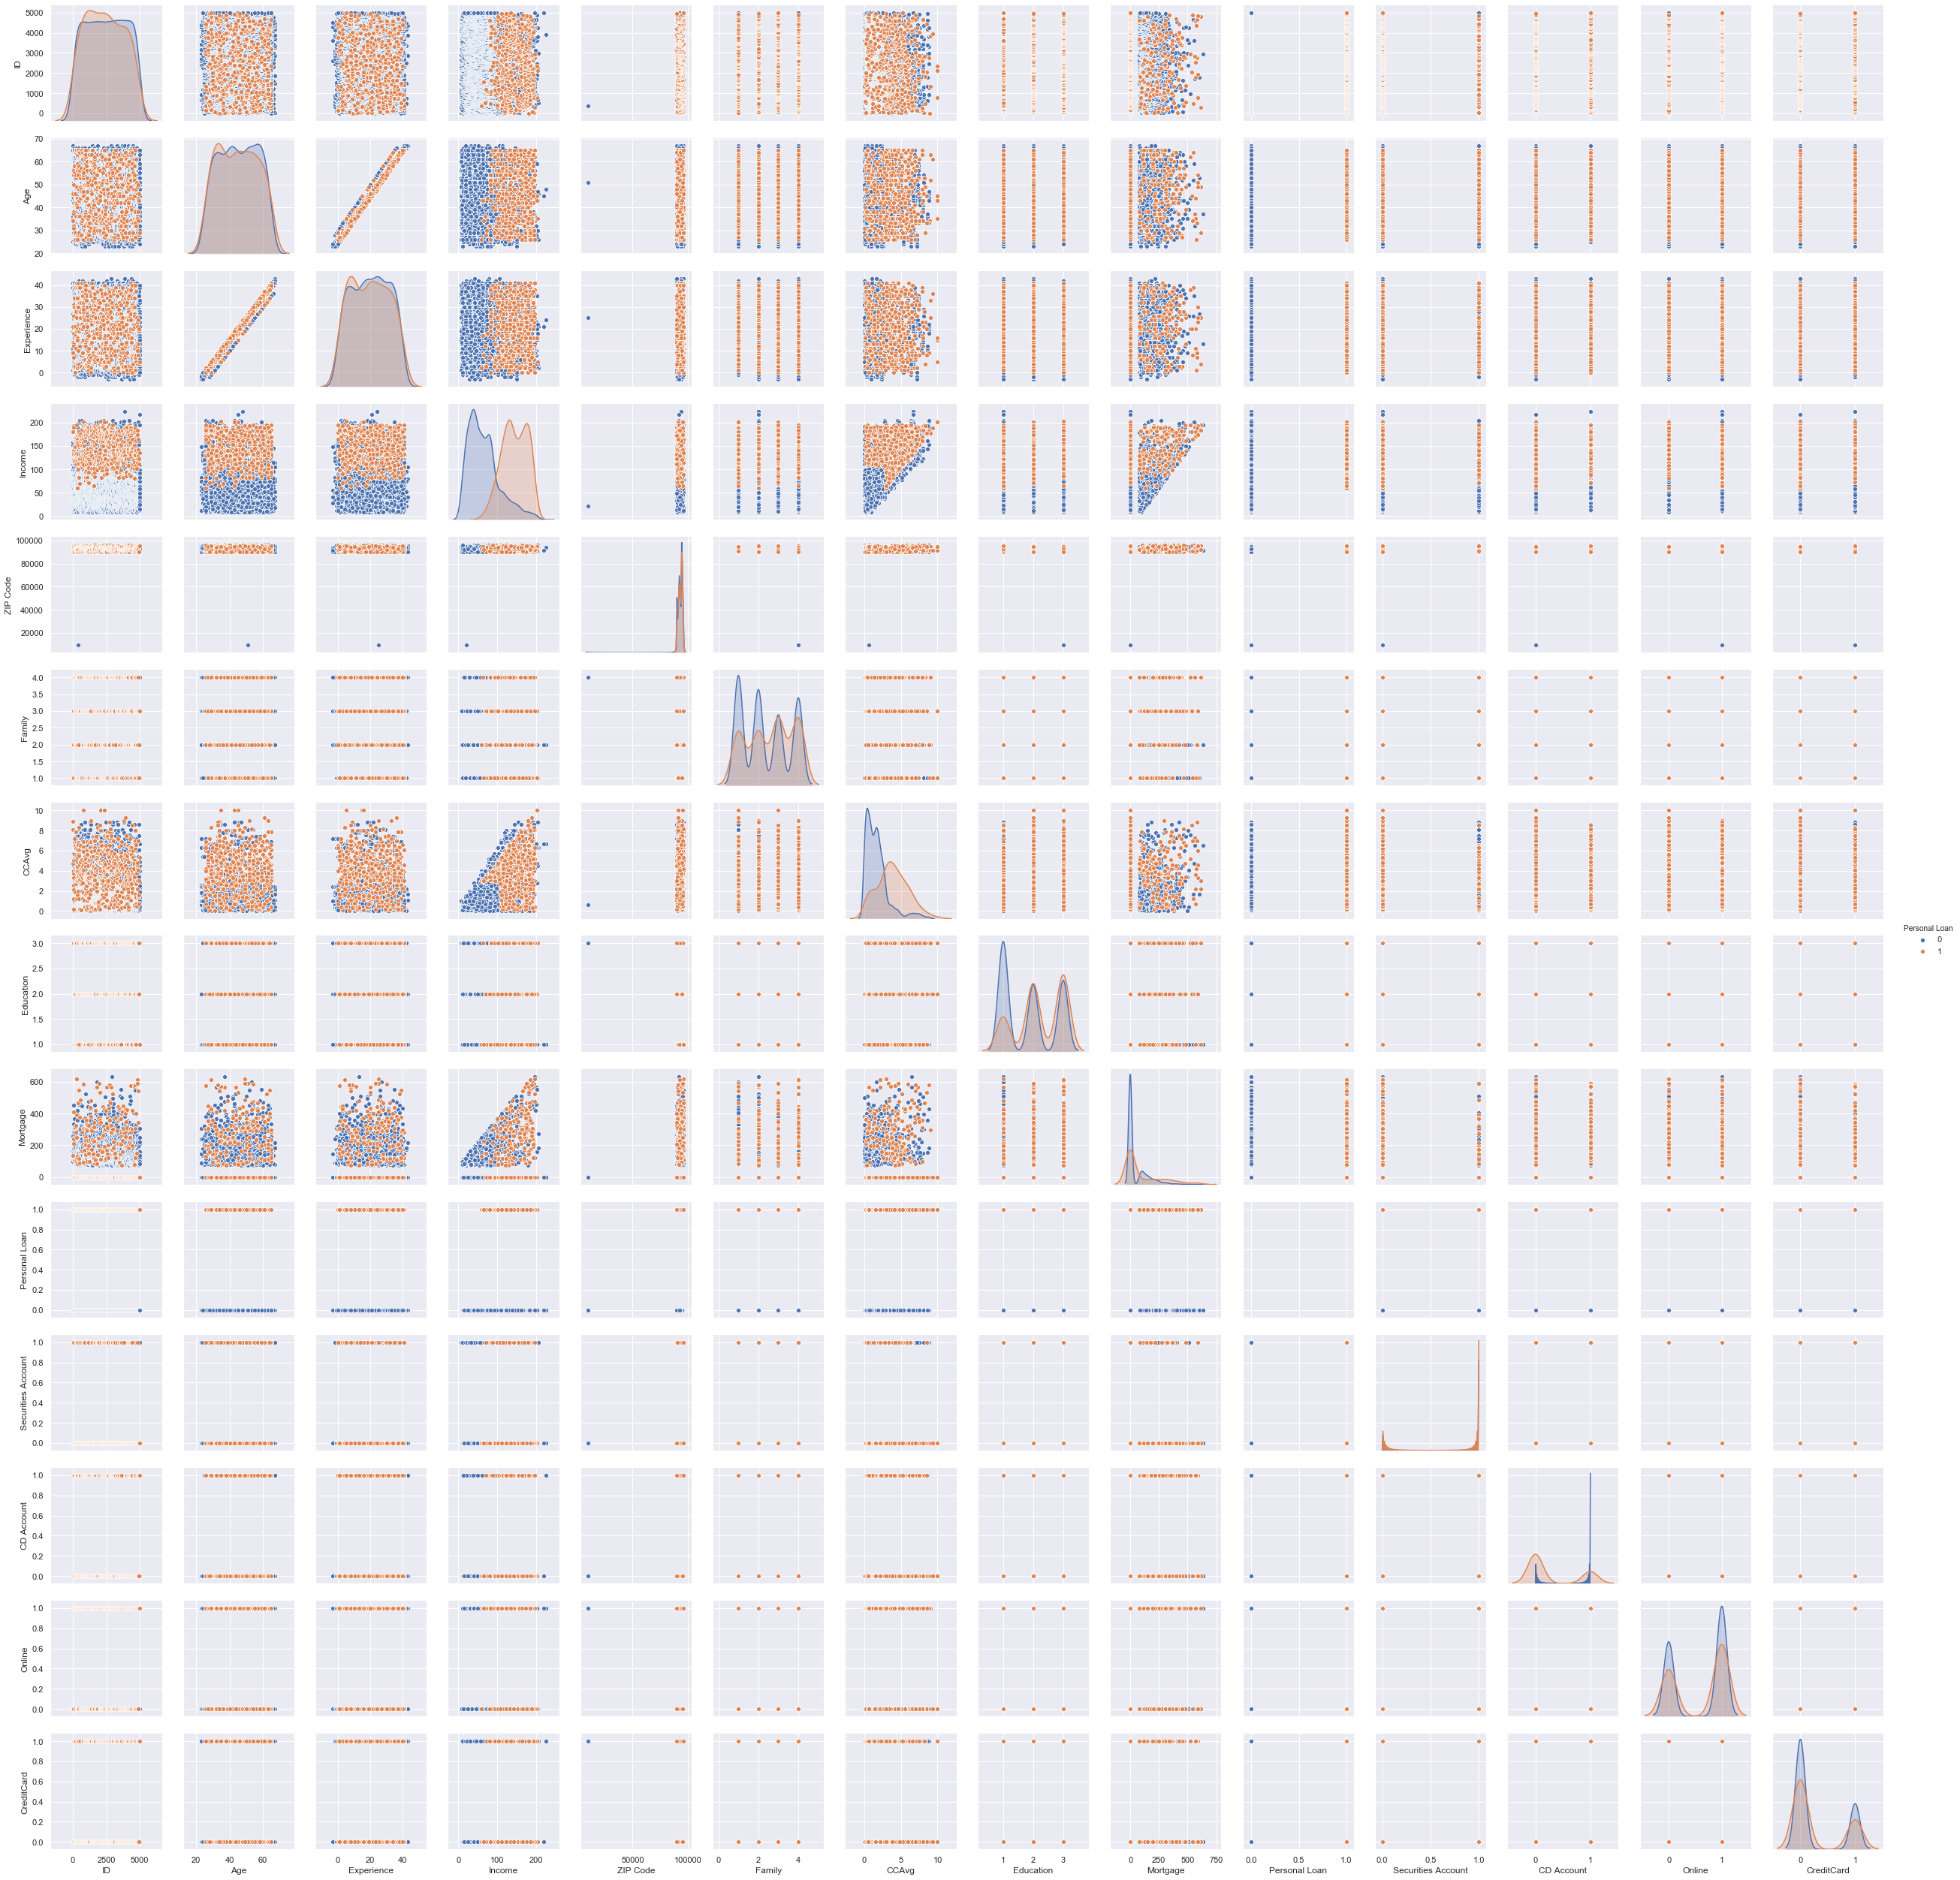

In [10]:
sns.pairplot(data=bank_df, diag_kind = 'kde', hue = 'Personal Loan')

#Age: shows a normal distribution mean=~median.
#Experience: shows a normal distribution mean=~median. But has some negative values that need to be handled.
#Income feature show a good seperation for the target variable and is right skewed. It would be a good feature for the classification.
#CCAvg and cd account features also show some linear seperation. so, these features will have some good contribution.
#Education and Mortgage also show some seperation.
#But Mortgage might give us a biased model since it has lot of outliers and data is skewed.

In [11]:
#Handling Negative Data in Experience Records
dfExp = bank_df.loc[bank_df['Experience'] >0]
negExp = bank_df.Experience < 0
column_name = 'Experience'
mylist = bank_df.loc[negExp]['ID'].tolist() #Ids of the customers with negative experience
len(mylist) # No. of negative experience customers

52

In [12]:
for id in mylist:   #Iterating through the negative ids
    age = bank_df.loc[np.where(bank_df['ID']==id)]["Age"].tolist()[0] #Getting Age of the Negative ID
    education = bank_df.loc[np.where(bank_df['ID']==id)]["Education"].tolist()[0] #Getting Education of the Negative ID
    df_filtered = dfExp[(dfExp.Age == age) & (dfExp.Education == education)] #Getting the data from the non negative dataframe matching the age and education
    exp = df_filtered['Experience'].median() #Getting the median of the Experience feature from the above extracted data
    bank_df.loc[bank_df.loc[np.where(bank_df['ID']==id)].index, 'Experience'] = exp #Replacting the negative experience column with the above extracted median

In [13]:
bank_df[bank_df['Experience'] < 0]['Experience'].count()

0

In [14]:
#Since there were few records where the filter in the above steps didn't match, values were saved as nan
#Handling missing data in Experience feature.
bank_df.isna().sum()

ID                     0
Age                    0
Experience            29
Income                 0
ZIP Code               0
Family                 0
CCAvg                  0
Education              0
Mortgage               0
Personal Loan          0
Securities Account     0
CD Account             0
Online                 0
CreditCard             0
dtype: int64

In [15]:
#Replacing the missing value with the median value
bank_df['Experience'].fillna(bank_df['Experience'].median(), inplace=True)
bank_df['Experience'].isna().sum()

0

In [16]:
bank_df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.241800,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.326208,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,0.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## Checking the Correlation Between Features and Target using Heatmap

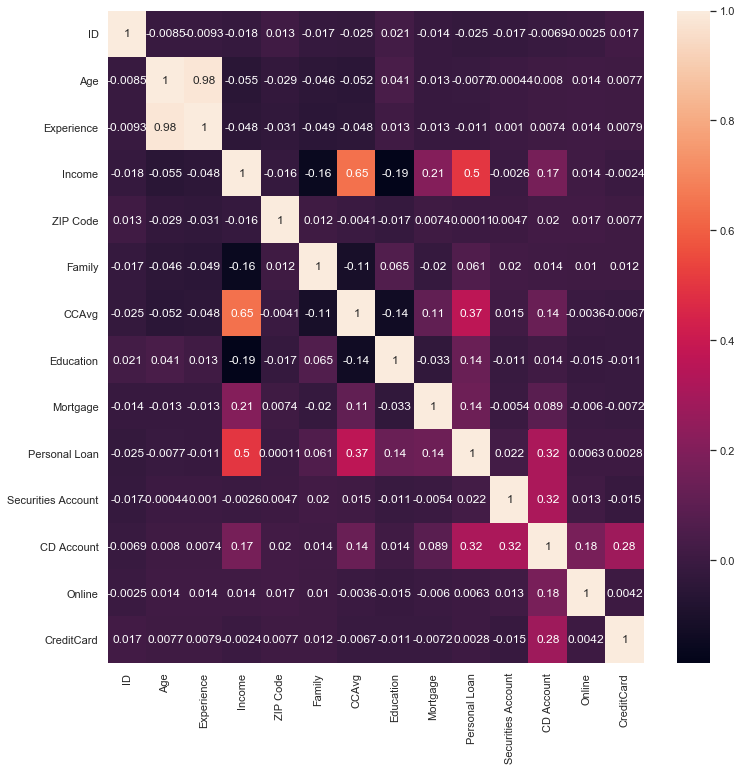

In [17]:
# Now we will look at the linear relationship of the features with the target
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(bank_df.corr(),annot=True)
bottom, top = ax.get_ylim()
ax = ax.set_ylim(bottom + 0.5, top - 0.5)

In [18]:
#The target variable(Personal Loan) has strong relationship with Income, CCAvg, CD Account, Education and Mortgage. 
#Some more detailed observation on these fields is shown below
#Although, the other features doesn't show a colinearity with the target variable, doesn't mean we drop. It migh have non-linear relationship.
#Some features also show corelation within themselves, so we can use the PCA to increase the SNR i.e., Signal to Noise Ratio

#### Observing CD Account

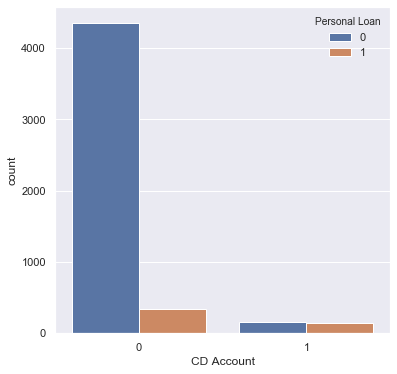

In [19]:
ax = sns.set(rc={'figure.figsize':(6,6)})
ax = sns.countplot(x="CD Account", data=bank_df,hue="Personal Loan")

#Majority of the Customers who haven't taken personal loan don't have CD Account as well. There is a good seperation.
#So, CD Account will be a good predictor

#### Observing CCAvg Feature

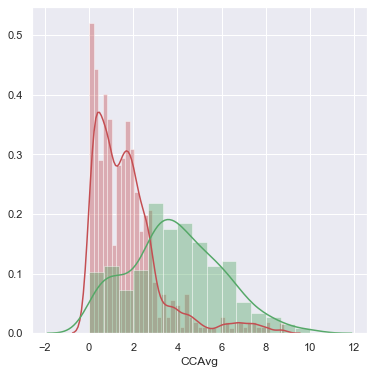

In [20]:
ax = sns.set(rc={'figure.figsize':(6,6)})
ax = sns.distplot( bank_df[bank_df['Personal Loan'] == 0]['CCAvg'], color = 'r')
ax = sns.distplot( bank_df[bank_df['Personal Loan'] == 1]['CCAvg'], color = 'g')

#Customers who have taken personal loan have higher credit card average compared to the ones who didn't take the loan.
#So, CCAvg will be a good predictor

#### Observing Income Feature

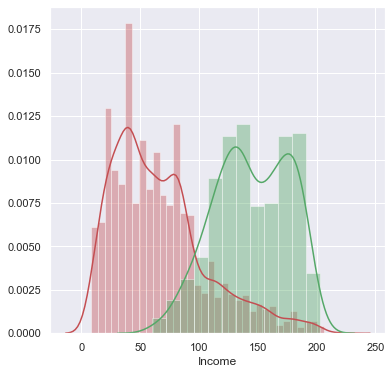

In [21]:
ax = sns.set(rc={'figure.figsize':(6,6)})
sns.distplot( bank_df[bank_df['Personal Loan'] == 0]['Income'], color = 'r')
sns.distplot( bank_df[bank_df['Personal Loan'] == 1]['Income'], color = 'g')

#Income is high for the customers who opted for loan and comparitely low for customers who didn't take loan.
#So, Income will be a good predictor

#### Observing Education Feature

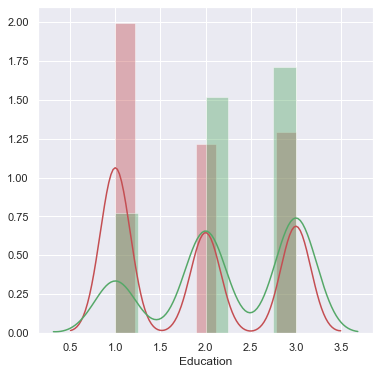

In [22]:
sns.distplot( bank_df[bank_df['Personal Loan'] == 0]['Education'], color = 'r')
sns.distplot( bank_df[bank_df['Personal Loan'] == 1]['Education'], color = 'g')

#People who opted for loan, majority of them have higher education. Some pattern is observed.
#So, Education will be a decent feature that can be used.

#### Observing securities Account

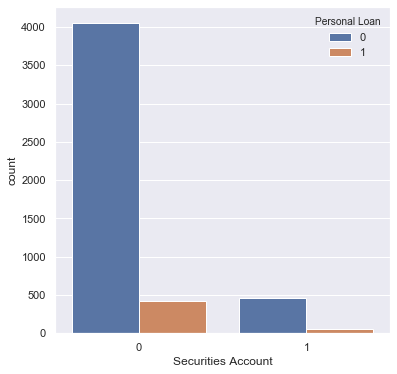

In [23]:
sns.countplot(x="Securities Account", data=bank_df,hue="Personal Loan")
#There is a good seperation with Securities Account Feature. We can use this feature as a predictor.

#### Observing Credit Card Feature

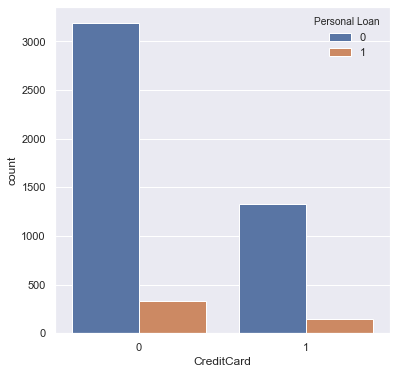

In [24]:
sns.countplot(x="CreditCard", data=bank_df,hue="Personal Loan")
#There is a good seperation with CreditCard Feature. We can use this feature as a predictor.

#### Observing ZIP Code Values

In [25]:
zipcode_top10 = bank_df[bank_df['Personal Loan']==1]['ZIP Code'].value_counts().head(10)
zipcode_top10

#Customers who opted for loan also show some pattern with ZIP Code.
#So we can't elimnate this feature

94720    19
94305    13
92093     9
90095     8
90089     8
94304     8
92182     7
94022     6
95051     6
95616     6
Name: ZIP Code, dtype: int64

#### Observing Family Feature

In [26]:
familysize_no = np.mean( bank_df[bank_df['Personal Loan'] == 0]['Family'] )
familysize_no

2.3734513274336284

In [27]:
familysize_yes = np.mean( bank_df[bank_df['Personal Loan']  == 1]['Family'] )
familysize_yes

2.6125

In [28]:
from scipy import stats

stats.ttest_ind(bank_df[bank_df['Personal Loan']  == 0]['Family'], bank_df[bank_df['Personal Loan']  == 1]['Family'])

#Family size seems to have no impact on decision to take a loan.

Ttest_indResult(statistic=-4.34662958524817, pvalue=1.4099040685673807e-05)

#### Observing Age Feature

In [29]:
age_no = np.mean( bank_df[bank_df['Personal Loan'] == 0]['Age'] )
age_no

45.36725663716814

In [30]:
age_yes = np.mean( bank_df[bank_df['Personal Loan']  == 1]['Age'] )
age_yes

45.06666666666667

In [31]:
from scipy import stats

stats.ttest_ind(bank_df[bank_df['Personal Loan']  == 0]['Age'], bank_df[bank_df['Personal Loan']  == 1]['Age'])

Ttest_indResult(statistic=0.5461906615539323, pvalue=0.584959263705325)

#### Observing Mortgage feature

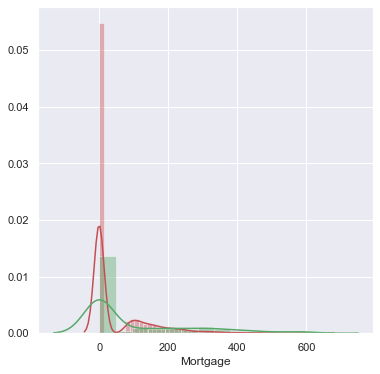

In [32]:
ax = sns.set(rc={'figure.figsize':(6,6)})
sns.distplot( bank_df[bank_df['Personal Loan'] == 0]['Mortgage'], color = 'r')
sns.distplot( bank_df[bank_df['Personal Loan'] == 1]['Mortgage'], color = 'g')
# Mortgage data is skewed towards the right but show a significant difference between customers who took loan and who didn't.

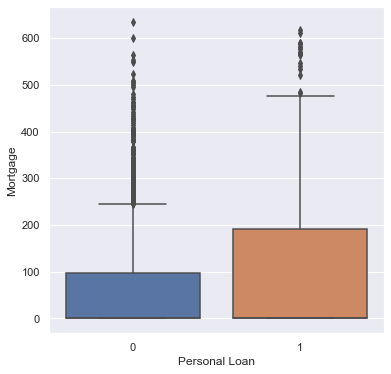

In [33]:
sns.boxplot(x='Personal Loan', y='Mortgage', data=bank_df)

# Lot of outliers observed at higher side in the Mortgage value for the customers who didn't opt for a personal Loan.

#### Age and Experience are highly correlated. We won't use Experience feature.
#### Income and CCAvg also strongly corelated. We won't use CCAvg feature.

In [34]:
# We will now check for the outliers and handle it.
# Since Education is not a numerical data, we need not have to look for outliers there, same with the CD Account.
# From the pairplot, We observed outliers for CCAvg, Income and Mortgage features
# From the below boxplots we can see that all these features have lot of outliers and we need to handle them.

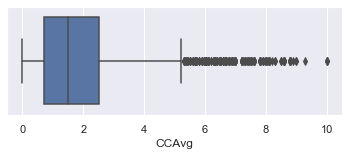

In [35]:
ax = sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x='CCAvg', data=bank_df)

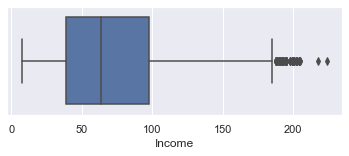

In [36]:
ax = sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x='Income', data=bank_df)

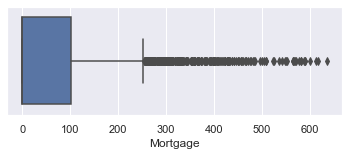

In [37]:
ax = sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x='Mortgage', data=bank_df)

64.0
170.0


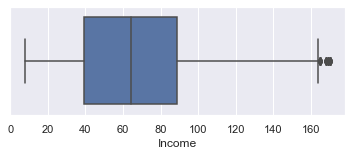

In [38]:
#Replacing the extreme values in Income feature with median values

print(bank_df['Income'].quantile(0.50)) 
print(bank_df['Income'].quantile(0.95)) 
bank_df['Income'] = np.where(bank_df['Income'] > bank_df['Income'].quantile(0.95), bank_df['Income'].quantile(0.50), bank_df['Income'])
ax = sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x='Income', data=bank_df)

1.5
6.0


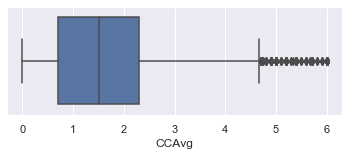

In [39]:
#Replacing the extreme values in CCAvg feature with median values

print(bank_df['CCAvg'].quantile(0.50)) 
print(bank_df['CCAvg'].quantile(0.95)) 
bank_df['CCAvg'] = np.where(bank_df['CCAvg'] > bank_df['CCAvg'].quantile(0.95), bank_df['CCAvg'].quantile(0.50), bank_df['CCAvg'])
ax = sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x='CCAvg', data=bank_df)

0.0
272.0


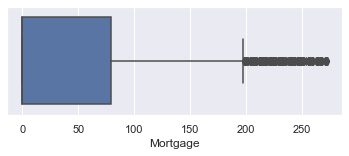

In [40]:
#Replacing the extreme values in Mortgage feature with median values

print(bank_df['Mortgage'].quantile(0.50)) 
print(bank_df['Mortgage'].quantile(0.95)) 
bank_df['Mortgage'] = np.where(bank_df['Mortgage'] > bank_df['Mortgage'].quantile(0.95), bank_df['Mortgage'].quantile(0.50), bank_df['Mortgage'])
ax = sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x='Mortgage', data=bank_df)

# Using All Features except 'ID','Experience','CCAvg' and 'Family' based on EDA

## Standardizing the Data and Splitting the data into Train and Test

In [41]:
# Dropping 'ID','Experience','CCAvg' and 'Family' features as there in no impact on target based on EDA

X = bank_df.drop(labels=['Personal Loan','ID','Experience','CCAvg','Family'], axis =1)
y = bank_df['Personal Loan']

In [42]:
# We will now use a standardscaler to standardize the data
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_std,y, shuffle = True,test_size=0.3, random_state=16)

## Logistic Regression Model

In [44]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [45]:
test_predict = model.predict(X_test)
test_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [46]:
print("Logistic Regression model score on train data: ",model.score(X_train,y_train))
print("Logistic Regression model score on test data: ",model.score(X_test,y_test))
print("The confusion matrix for the Logistic Regression model is:")
metrics.confusion_matrix(y_test, test_predict)

# From below confusion matrix, we can make below inferences:
# True Positives (TP): we correctly predicted 1341 people won't be opting for a personal loan
# True Negatives (TN): we correctly predicted 58 people will opt for a loan
# False Positives (FP): we incorrectly predicted that 9 people would be taking a loan (a "Type I error") 9 Falsely predict positive Type I error
# False Negatives (FN): we incorrectly predicted that 92 people wouldn't opt for a loan (a "Type II error") 92 Falsely predict negative Type II error

Logistic Regression model score on train data:  0.938
Logistic Regression model score on test data:  0.9326666666666666
The confusion matrix for the Logistic Regression model is:


array([[1341,    9],
       [  92,   58]], dtype=int64)

In [47]:
# We definetely want to up our recall score, as we will be losing potential customers who can take up the loan.

In [48]:
y_predictprob = model.predict_proba(X_train)
y_predictprob

#Column 1 is the probability that customer doesn't opt for loan
#Column 2 is the probability that customer opts for a loan

array([[0.98948186, 0.01051814],
       [0.99602324, 0.00397676],
       [0.98270539, 0.01729461],
       ...,
       [0.97138436, 0.02861564],
       [0.99819646, 0.00180354],
       [0.99796834, 0.00203166]])

In [49]:
np.where(model.predict_proba(X_train)[:,1]>0.5,1,0)[0:10]
# Currently we require only the customers who would take up the loan, so using the 2nd column [:,1]
# 0.5 is the default threshold we taken, we need to identify the optimal threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, y_predictprob[::,1])

In [51]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9013832329605199

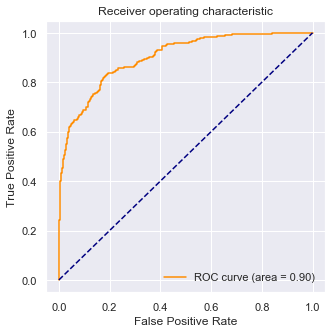

In [52]:
plt.figure(figsize=(5 , 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [53]:
### Unoptimized probability threshold based performance numbers
# Train accuracy numbers
trainPreds = np.where(model.predict_proba(X_train)[:,1] > 0.5, 1, 0)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainF1score = f1_score(y_train, trainPreds)
trainResults=[X_train.shape[0], 0.5, trainAccuracy, trainRecall, trainPrecision, trainF1score]
# Test accuracy numbers
testPreds = np.where(model.predict_proba(X_test)[:,1] > 0.5, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[X_test.shape[0], 0.5, testAccuracy, testRecall, testPrecision, testF1score]

In [54]:
optimalF1 = 0
optimalTh = 0
for th in thresholds:
    preds = np.where(model.predict_proba(X_train)[:,1]>th,1,0)
    f1score = f1_score(y_train,preds)
    if(optimalF1<f1score):
        optimalF1 = f1score
        optimalTh = th

In [55]:
trainpreds = np.where(model.predict_proba(X_train)[:,1]>optimalTh,1,0)
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
trainF1score = f1_score(y_train, trainpreds)
optimalTrainResults=[X_train.shape[0], optimalTh, trainaccuracy, trainrecall, trainprecision, trainF1score]
# Optimal probability threshold based test accuracy numbers
testPreds = np.where(model.predict_proba(X_test)[:,1] > optimalTh, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
optimalTestResults=[X_test.shape[0], optimalTh, testAccuracy, testRecall, testPrecision, testF1score]

In [56]:
 # Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalTh", "accuracy", "recall", "precision", "f1_score"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults

In [57]:
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalTh,0.293357,0.293357,0.500000,0.500000
accuracy,0.928857,0.922667,0.938000,0.932667
recall,0.593939,0.506667,0.430303,0.386667
precision,0.630225,0.644068,0.830409,0.865672
f1_score,0.611544,0.567164,0.566866,0.534562


In [58]:
# Confusion matrix on the optimal threshold
print("The confusion matrix for the Logistic Regression model after optimatization is:")
metrics.confusion_matrix(y_test, testPreds)

The confusion matrix for the Logistic Regression model after optimatization is:


array([[1308,   42],
       [  74,   76]], dtype=int64)

## KNeighborsClassifier

In [59]:
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [60]:
print("Train accuracy: ", KNN_model.score(X_train, y_train))
print("Test accuracy: ", KNN_model.score(X_test, y_test))
# Confusion matrix of the KNN model without optimal K
print("The confusion matrix for the KNN model without optimal k:")
metrics.confusion_matrix(y_test, KNN_model.predict(X_test))

# From below confusion matrix, we can make below inferences:
# True Positives (TP): we correctly predicted 1336 people won't be opting for a personal loan
# True Negatives (TN): we correctly predicted 60 people will opt for a loan
# False Positives (FP): we incorrectly predicted that 14 people would be taking a loan (a "Type I error") 14 Falsely predict positive Type I error
# False Negatives (FN): we incorrectly predicted that 90 people wouldn't opt for a loan (a "Type II error") 90 Falsely predict negative Type II error

Train accuracy:  0.9508571428571428
Test accuracy:  0.9306666666666666
The confusion matrix for the KNN model without optimal k:


array([[1336,   14],
       [  90,   60]], dtype=int64)

In [61]:
# We have to increase the recall rate in this case as well.

In [62]:
#Train Data Prediction, Accuracy, Recall and Precision without optimization
trainPreds = KNN_model.predict(X_train)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainResults=[X_train.shape[0], 5, trainAccuracy, trainRecall, trainPrecision]

#Test Data Prediction, Accuracy, Recall and Precision without optimization
testPreds = KNN_model.predict(X_test)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[X_test.shape[0], 5, testAccuracy, testRecall, testPrecision]

In [63]:
# Finding the optimal K to find the best fit model
maxk = int(np.sqrt(X_train.shape[0]))
maxk

59

In [64]:
optimalK = 1
optimalTrainAccuracy = 0
for k_i in range(maxk):
    if(((k_i%2)!=0)&(k_i>1)):
        KNN_model = KNeighborsClassifier(n_neighbors=k_i)
        KNN_model.fit(X_train, y_train)
        if(KNN_model.score(X_train, y_train)>optimalTrainAccuracy):
            optimalK = k_i
            optimalTrainAccuracy = KNN_model.score(X_train, y_train)
print((optimalK, optimalTrainAccuracy))

(3, 0.958)


In [65]:
KNN_model = KNeighborsClassifier(n_neighbors=3) # optimal k being 3
KNN_model.fit(X_train, y_train)
KNN_model.score(X_train, y_train)

0.958

In [66]:
print("Train accuracy on optimal K: ", KNN_model.score(X_train, y_train))
print("Test accuracy on optimal K: ", KNN_model.score(X_test, y_test))

Train accuracy on optimal K:  0.958
Test accuracy on optimal K:  0.9293333333333333


In [67]:
#Train data prediction and accurancy based on optimal k
trainpreds = KNN_model.predict(X_train) 
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
optimalTrainResults=[X_train.shape[0], optimalK, trainaccuracy, trainrecall, trainprecision]
#Test data prediction and accurancy based on optimal k
testPreds = KNN_model.predict(X_test) 
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
optimalTestResults=[X_test.shape[0], optimalK, testAccuracy, testRecall, testPrecision]

In [68]:
 # Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalK", "accuracy", "recall", "precision"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalK,3.000000,3.000000,5.000000,5.000000
accuracy,0.958000,0.929333,0.950857,0.930667
recall,0.633333,0.440000,0.542424,0.400000
precision,0.889362,0.750000,0.895000,0.810811


In [69]:
# Confusion matrix of the KNN model with optimal K
print("The confusion matrix for the KNN model with optimal k:")
metrics.confusion_matrix(y_test, KNN_model.predict(X_test))

#The recall hasn't improved much as well as the precision. Its not giving great results on test data especially the recall.

The confusion matrix for the KNN model with optimal k:


array([[1328,   22],
       [  84,   66]], dtype=int64)

## Naive Bayes Model

In [70]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [71]:
test_predict = NB_model.predict(X_test)
test_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [72]:
print("Gaussian Naive Bayes Model Score on train data: ", NB_model.score(X_train, y_train))
print("Gaussian Naive Bayes Model Score on test data: ", NB_model.score(X_test, y_test))
# Confusion Matrix for Naive Bayes Model without any optimization
print("Confusion matrix for Naive Bayes without any optimization:\n")
metrics.confusion_matrix(y_test,test_predict)

Gaussian Naive Bayes Model Score on train data:  0.9017142857142857
Gaussian Naive Bayes Model Score on test data:  0.9046666666666666
Confusion matrix for Naive Bayes without any optimization:



array([[1311,   39],
       [ 104,   46]], dtype=int64)

In [73]:
pd.DataFrame(data=[accuracy_score(y_test, test_predict), 
                   recall_score(y_test, test_predict), 
                   precision_score(y_test, test_predict),
                   f1_score(y_test, test_predict)], 
             index=["accuracy", "recall", "precision", "f1_score"])
#Recall has badly taken the hit here and needs to be improved

,0
accuracy,0.904667
recall,0.306667
precision,0.541176
f1_score,0.391489


In [74]:
y_predictprob = NB_model.predict_proba(X_train)
y_predictprob
#Column 1 is the probability that customer doesn't opt for loan
#Column 2 is the probability that customer opts for a loan

array([[0.9969417 , 0.0030583 ],
       [0.99745706, 0.00254294],
       [0.99572264, 0.00427736],
       ...,
       [0.9947603 , 0.0052397 ],
       [0.99420553, 0.00579447],
       [0.99502287, 0.00497713]])

In [75]:
np.where(NB_model.predict_proba(X_train)[:,1]>0.5,1,0)[0:10]
# Currently we require only the customers who would take up the loan, so using the 2nd column [:,1]
# 0.5 is the default threshold we taken, we need to identify the optimal threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [76]:
fpr, tpr, thresholds = roc_curve(y_train, y_predictprob[::,1])

In [77]:
roc_auc = auc(fpr,tpr)
roc_auc

0.873373482458656

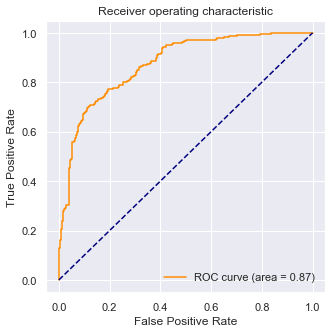

In [78]:
plt.figure(figsize=(5 , 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [79]:
### Unoptimized probability threshold based performance numbers
# Train accuracy numbers
trainPreds = np.where(NB_model.predict_proba(X_train)[:,1] > 0.5, 1, 0)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainF1score = f1_score(y_train, trainPreds)
trainResults=[X_train.shape[0], 0.5, trainAccuracy, trainRecall, trainPrecision, trainF1score]
# Test accuracy numbers
testPreds = np.where(NB_model.predict_proba(X_test)[:,1] > 0.5, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[X_test.shape[0], 0.5, testAccuracy, testRecall, testPrecision, testF1score]

In [80]:
optimalF1 = 0
optimalTh = 0
for th in thresholds:
    preds = np.where(NB_model.predict_proba(X_train)[:,1]>th,1,0)
    f1score = f1_score(y_train,preds)
    if(optimalF1<f1score):
        optimalF1 = f1score
        optimalTh = th

In [81]:
trainpreds = np.where(NB_model.predict_proba(X_train)[:,1]>optimalTh,1,0)
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
trainF1score = f1_score(y_train, trainpreds)
optimalTrainResults=[X_train.shape[0], optimalTh, trainaccuracy, trainrecall, trainprecision, trainF1score]

# Optimal probability threshold based test accuracy numbers
testPreds = np.where(NB_model.predict_proba(X_test)[:,1] > optimalTh, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
optimalTestResults=[X_test.shape[0], optimalTh, testAccuracy, testRecall, testPrecision, testF1score]

In [82]:
# Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalTh", "accuracy", "recall", "precision", "f1_score"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalTh,0.205142,0.205142,0.500000,0.500000
accuracy,0.909429,0.907333,0.901714,0.904667
recall,0.554545,0.440000,0.333333,0.306667
precision,0.518414,0.545455,0.470085,0.541176
f1_score,0.535871,0.487085,0.390071,0.391489


In [83]:
# Confusion matrix for Naive Bayes Model on the optimal threshold
print("The confusion matrix for the Naive Bayes model after optimatization is:")
metrics.confusion_matrix(y_test, testPreds)

The confusion matrix for the Naive Bayes model after optimatization is:


array([[1295,   55],
       [  84,   66]], dtype=int64)

# Using Only Colinear Features (Refer Heatmap Above)

## Standardizing the Data and Splitting the data into Train and Test

In [84]:
# Dropping 'ID','Experience','CCAvg' and 'Family' features as there in no impact on target based on EDA

X = bank_df.loc[:,['Income','CCAvg','Education','Mortgage','CD Account']]
y = bank_df['Personal Loan']

In [85]:
# We will now use a standardscaler to standardize the data
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_std,y, shuffle = True,test_size=0.3, random_state=16)

## Logistic Regression Model

In [87]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
test_predict = model.predict(X_test)
test_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [89]:
print("Logistic Regression model score on train data: ",model.score(X_train,y_train))
print("Logistic Regression model score on test data: ",model.score(X_test,y_test))
print("The confusion matrix for the Logistic Regression model is:")
metrics.confusion_matrix(y_test, test_predict)

# From below confusion matrix, we can make below inferences:
# True Positives (TP): we correctly predicted 1340 people won't be opting for a personal loan
# True Negatives (TN): we correctly predicted 64 people will opt for a loan
# False Positives (FP): we incorrectly predicted that 10 people would be taking a loan (a "Type I error") 10 Falsely predict positive Type I error
# False Negatives (FN): we incorrectly predicted that 86 people wouldn't opt for a loan (a "Type II error") 86 Falsely predict negative Type II error

Logistic Regression model score on train data:  0.9354285714285714
Logistic Regression model score on test data:  0.936
The confusion matrix for the Logistic Regression model is:


array([[1340,   10],
       [  86,   64]], dtype=int64)

In [90]:
# We definetely want to up our recall score, as we will be losing potential customers who can take up the loan.

In [91]:
y_predictprob = model.predict_proba(X_train)
y_predictprob

#Column 1 is the probability that customer doesn't opt for loan
#Column 2 is the probability that customer opts for a loan

array([[0.99401914, 0.00598086],
       [0.99798602, 0.00201398],
       [0.99097104, 0.00902896],
       ...,
       [0.99023834, 0.00976166],
       [0.99396167, 0.00603833],
       [0.99565892, 0.00434108]])

In [92]:
np.where(model.predict_proba(X_train)[:,1]>0.5,1,0)[0:10]
# Currently we require only the customers who would take up the loan, so using the 2nd column [:,1]
# 0.5 is the default threshold we taken, we need to identify the optimal threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [93]:
fpr, tpr, thresholds = roc_curve(y_train, y_predictprob[::,1])

In [94]:
roc_auc = auc(fpr, tpr)
roc_auc

0.906893222445273

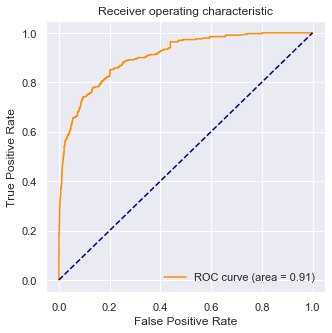

In [95]:
plt.figure(figsize=(5 , 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [96]:
### Unoptimized probability threshold based performance numbers
# Train accuracy numbers
trainPreds = np.where(model.predict_proba(X_train)[:,1] > 0.5, 1, 0)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainF1score = f1_score(y_train, trainPreds)
trainResults=[X_train.shape[0], 0.5, trainAccuracy, trainRecall, trainPrecision, trainF1score]
# Test accuracy numbers
testPreds = np.where(model.predict_proba(X_test)[:,1] > 0.5, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[X_test.shape[0], 0.5, testAccuracy, testRecall, testPrecision, testF1score]

In [97]:
optimalF1 = 0
optimalTh = 0
for th in thresholds:
    preds = np.where(model.predict_proba(X_train)[:,1]>th,1,0)
    f1score = f1_score(y_train,preds)
    if(optimalF1<f1score):
        optimalF1 = f1score
        optimalTh = th

In [98]:
trainpreds = np.where(model.predict_proba(X_train)[:,1]>optimalTh,1,0)
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
trainF1score = f1_score(y_train, trainpreds)
optimalTrainResults=[X_train.shape[0], optimalTh, trainaccuracy, trainrecall, trainprecision, trainF1score]
# Optimal probability threshold based test accuracy numbers
testPreds = np.where(model.predict_proba(X_test)[:,1] > optimalTh, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
optimalTestResults=[X_test.shape[0], optimalTh, testAccuracy, testRecall, testPrecision, testF1score]

In [99]:
 # Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalTh", "accuracy", "recall", "precision", "f1_score"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults

In [100]:
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalTh,0.358045,0.358045,0.500000,0.500000
accuracy,0.936286,0.932667,0.935429,0.936000
recall,0.560606,0.526667,0.433333,0.426667
precision,0.703422,0.724771,0.785714,0.864865
f1_score,0.623946,0.610039,0.558594,0.571429


In [101]:
# Confusion matrix on the optimal threshold
print("The confusion matrix for the Logistic Regression model after optimatization is:")
metrics.confusion_matrix(y_test, testPreds)

The confusion matrix for the Logistic Regression model after optimatization is:


array([[1320,   30],
       [  71,   79]], dtype=int64)

## KNeighborsClassifier

In [102]:
KNN_model = KNeighborsClassifier()
KNN_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [103]:
print("Train accuracy: ", KNN_model.score(X_train, y_train))
print("Test accuracy: ", KNN_model.score(X_test, y_test))
# Confusion matrix of the KNN model without optimal K
print("The confusion matrix for the KNN model without optimal k:")
metrics.confusion_matrix(y_test, KNN_model.predict(X_test))

# From below confusion matrix, we can make below inferences:
# True Positives (TP): we correctly predicted 1334 people won't be opting for a personal loan
# True Negatives (TN): we correctly predicted 96 people will opt for a loan
# False Positives (FP): we incorrectly predicted that 16 people would be taking a loan (a "Type I error") 16 Falsely predict positive Type I error
# False Negatives (FN): we incorrectly predicted that 54 people wouldn't opt for a loan (a "Type II error") 54 Falsely predict negative Type II error

Train accuracy:  0.964
Test accuracy:  0.9533333333333334
The confusion matrix for the KNN model without optimal k:


array([[1334,   16],
       [  54,   96]], dtype=int64)

In [104]:
# We have to increase the recall rate in this case as well.

In [105]:
#Train Data Prediction, Accuracy, Recall and Precision without optimization
trainPreds = KNN_model.predict(X_train)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainResults=[X_train.shape[0], 5, trainAccuracy, trainRecall, trainPrecision]

#Test Data Prediction, Accuracy, Recall and Precision without optimization
testPreds = KNN_model.predict(X_test)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[X_test.shape[0], 5, testAccuracy, testRecall, testPrecision]

In [106]:
# Finding the optimal K to find the best fit model
maxk = int(np.sqrt(X_train.shape[0]))
maxk

59

In [107]:
optimalK = 1
optimalTrainAccuracy = 0
for k_i in range(maxk):
    if(((k_i%2)!=0)&(k_i>1)):
        KNN_model = KNeighborsClassifier(n_neighbors=k_i)
        KNN_model.fit(X_train, y_train)
        if(KNN_model.score(X_train, y_train)>optimalTrainAccuracy):
            optimalK = k_i
            optimalTrainAccuracy = KNN_model.score(X_train, y_train)
print((optimalK, optimalTrainAccuracy))

(3, 0.9734285714285714)


In [108]:
KNN_model = KNeighborsClassifier(n_neighbors=3) # optimal k being 3
KNN_model.fit(X_train, y_train)
KNN_model.score(X_train, y_train)

0.9734285714285714

In [109]:
print("Train accuracy on optimal K: ", KNN_model.score(X_train, y_train))
print("Test accuracy on optimal K: ", KNN_model.score(X_test, y_test))

Train accuracy on optimal K:  0.9734285714285714
Test accuracy on optimal K:  0.9546666666666667


In [110]:
#Train data prediction and accurancy based on optimal k
trainpreds = KNN_model.predict(X_train) 
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
optimalTrainResults=[X_train.shape[0], optimalK, trainaccuracy, trainrecall, trainprecision]
#Test data prediction and accurancy based on optimal k
testPreds = KNN_model.predict(X_test) 
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
optimalTestResults=[X_test.shape[0], optimalK, testAccuracy, testRecall, testPrecision]

In [111]:
 # Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalK", "accuracy", "recall", "precision"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalK,3.000000,3.000000,5.000000,5.000000
accuracy,0.973429,0.954667,0.964000,0.953333
recall,0.766667,0.660000,0.690909,0.640000
precision,0.940520,0.853448,0.904762,0.857143


In [112]:
# Confusion matrix of the KNN model with optimal K
print("The confusion matrix for the KNN model with optimal k:")
metrics.confusion_matrix(y_test, KNN_model.predict(X_test))

#The recall hasn't improved much as well as the precision. Its not giving great results on test data especially the recall.

The confusion matrix for the KNN model with optimal k:


array([[1333,   17],
       [  51,   99]], dtype=int64)

## Naive Bayes Model

In [113]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [114]:
test_predict = NB_model.predict(X_test)
test_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [115]:
print("Gaussian Naive Bayes Model Score on train data: ", NB_model.score(X_train, y_train))
print("Gaussian Naive Bayes Model Score on test data: ", NB_model.score(X_test, y_test))
# Confusion Matrix for Naive Bayes Model without any optimization
print("Confusion matrix for Naive Bayes without any optimization:\n")
metrics.confusion_matrix(y_test,test_predict)

Gaussian Naive Bayes Model Score on train data:  0.8982857142857142
Gaussian Naive Bayes Model Score on test data:  0.902
Confusion matrix for Naive Bayes without any optimization:



array([[1285,   65],
       [  82,   68]], dtype=int64)

In [116]:
pd.DataFrame(data=[accuracy_score(y_test, test_predict), 
                   recall_score(y_test, test_predict), 
                   precision_score(y_test, test_predict),
                   f1_score(y_test, test_predict)], 
             index=["accuracy", "recall", "precision", "f1_score"])
#Recall has badly taken the hit here and needs to be improved

,0
accuracy,0.902000
recall,0.453333
precision,0.511278
f1_score,0.480565


In [117]:
y_predictprob = NB_model.predict_proba(X_train)
y_predictprob
#Column 1 is the probability that customer doesn't opt for loan
#Column 2 is the probability that customer opts for a loan

array([[9.98962965e-01, 1.03703527e-03],
       [9.99041330e-01, 9.58670219e-04],
       [9.98419220e-01, 1.58077959e-03],
       ...,
       [9.97984983e-01, 2.01501655e-03],
       [9.95898447e-01, 4.10155328e-03],
       [9.98259347e-01, 1.74065315e-03]])

In [118]:
np.where(NB_model.predict_proba(X_train)[:,1]>0.5,1,0)[0:10]
# Currently we require only the customers who would take up the loan, so using the 2nd column [:,1]
# 0.5 is the default threshold we taken, we need to identify the optimal threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [119]:
fpr, tpr, thresholds = roc_curve(y_train, y_predictprob[::,1])

In [120]:
roc_auc = auc(fpr,tpr)
roc_auc

0.8947242137462957

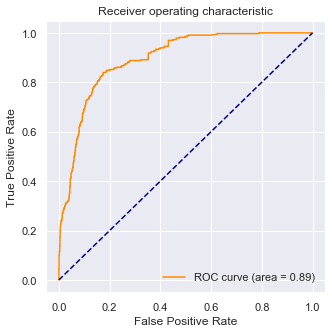

In [121]:
plt.figure(figsize=(5 , 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [122]:
### Unoptimized probability threshold based performance numbers
# Train accuracy numbers
trainPreds = np.where(NB_model.predict_proba(X_train)[:,1] > 0.5, 1, 0)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainF1score = f1_score(y_train, trainPreds)
trainResults=[X_train.shape[0], 0.5, trainAccuracy, trainRecall, trainPrecision, trainF1score]
# Test accuracy numbers
testPreds = np.where(NB_model.predict_proba(X_test)[:,1] > 0.5, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[X_test.shape[0], 0.5, testAccuracy, testRecall, testPrecision, testF1score]

In [123]:
optimalF1 = 0
optimalTh = 0
for th in thresholds:
    preds = np.where(NB_model.predict_proba(X_train)[:,1]>th,1,0)
    f1score = f1_score(y_train,preds)
    if(optimalF1<f1score):
        optimalF1 = f1score
        optimalTh = th

In [124]:
trainpreds = np.where(NB_model.predict_proba(X_train)[:,1]>optimalTh,1,0)
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
trainF1score = f1_score(y_train, trainpreds)
optimalTrainResults=[X_train.shape[0], optimalTh, trainaccuracy, trainrecall, trainprecision, trainF1score]

# Optimal probability threshold based test accuracy numbers
testPreds = np.where(NB_model.predict_proba(X_test)[:,1] > optimalTh, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
optimalTestResults=[X_test.shape[0], optimalTh, testAccuracy, testRecall, testPrecision, testF1score]

In [125]:
# Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalTh", "accuracy", "recall", "precision", "f1_score"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalTh,0.118735,0.118735,0.500000,0.500000
accuracy,0.876857,0.886000,0.898286,0.902000
recall,0.727273,0.753333,0.475758,0.453333
precision,0.413081,0.457490,0.461765,0.511278
f1_score,0.526894,0.569270,0.468657,0.480565


In [126]:
# Confusion matrix for Naive Bayes Model on the optimal threshold
print("The confusion matrix for the Naive Bayes model after optimatization is:")
metrics.confusion_matrix(y_test, testPreds)

#Best Recall of all the models built in this case

The confusion matrix for the Naive Bayes model after optimatization is:


array([[1216,  134],
       [  37,  113]], dtype=int64)

# Applying PCA and Then Fitting the Models

In [127]:
# Taking only those features that have colinear relationship with target
X = bank_df.loc[:,['Income','CCAvg','Education','Mortgage','CD Account']]
y = bank_df['Personal Loan']

In [128]:
# We will now use a standardscaler to standardize the data
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [129]:
X_std[0] # Post standandization, verify the 1st record in the dataset

array([-0.48933828, -0.0484978 , -1.04907792, -0.54536206, -0.25354028])

In [130]:
#Creating covariance matrix for identifying principal components
cov_matrix = np.cov(X_std.T)
pd.DataFrame(cov_matrix).transpose() # Displaying covariance in form of DataFrame for better understanding

,0,1,2,3,4
0,1.000200,0.478397,-0.186412,-0.055632,0.128508
1,0.478397,1.000200,-0.068869,-0.011879,0.124716
2,-0.186412,-0.068869,1.000200,0.015250,0.013937
3,-0.055632,-0.011879,0.015250,1.000200,-0.002735
4,0.128508,0.124716,0.013937,-0.002735,1.000200


In [131]:
#Getting eigen values and eigen vectors
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

In [132]:
pd.DataFrame(eig_values).transpose() # Eigen Values

,0,1,2,3,4
0,1.591038,0.504761,0.886474,1.025783,0.992943


In [133]:
pd.DataFrame(eig_vectors).transpose() # Eigen Vectors

,0,1,2,3,4
0,-0.665811,-0.630708,0.279336,0.083840,-0.271746
1,-0.722327,0.665087,-0.178190,-0.059541,0.024622
2,-0.175328,-0.378184,-0.596516,-0.028805,0.685256
3,0.056283,-0.124490,-0.652310,-0.385173,-0.638332
4,0.032119,0.036693,-0.329968,0.916645,-0.220238


In [134]:
#Finding Variance
variance = [(i/sum(eig_values))*100 for i in sorted(eig_values,reverse=True)]
pd.DataFrame(variance).transpose()

,0,1,2,3,4
0,31.814403,20.511566,19.854884,17.725938,10.093209


In [135]:
# Finding Cumulative Variance
cumulative_var = np.cumsum(variance)
pd.DataFrame(cumulative_var).transpose()

,0,1,2,3,4
0,31.814403,52.325969,72.180853,89.906791,100.0


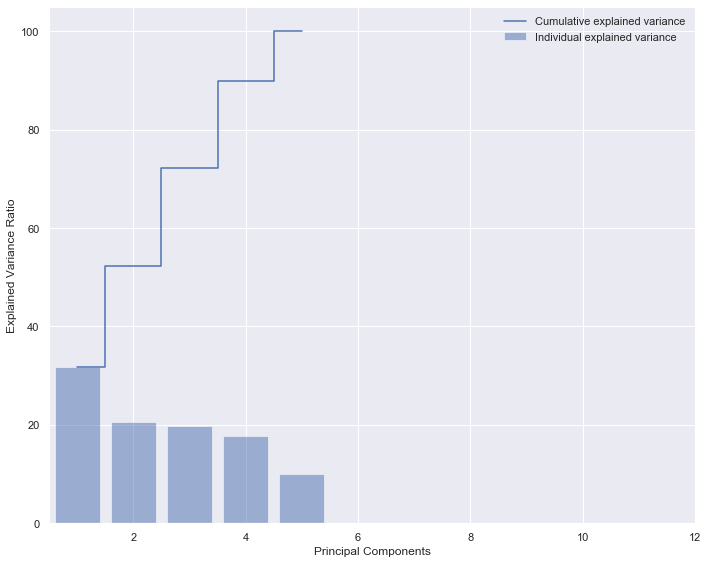

In [136]:
# Ploting 
plt.figure(figsize=(10 , 8))
plt.bar(range(1, eig_values.size + 1), variance, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_values.size + 1), cumulative_var, where='mid', label = 'Cumulative explained variance')
plt.xlim(0.5,12)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_std,y, shuffle = True,test_size=0.3, random_state=16)

In [138]:
#Taking all 4 components as they all are contributing to the signal/information
pca = PCA(n_components=5, random_state=2)
pca.fit(X_train) # Fitting the train model

PCA(copy=True, iterated_power='auto', n_components=5, random_state=2,
    svd_solver='auto', tol=0.0, whiten=False)

In [139]:
# Applying mapping of the PCA to both train and test data
train_proj = pca.transform(X_train)
test_proj = pca.transform(X_test)

## Logistic Regression Model

In [140]:
model = LogisticRegression()
model.fit(train_proj, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [141]:
test_predict = model.predict(test_proj)
test_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [142]:
print("Logistic Regression model score on train data: ",model.score(train_proj,y_train))
print("Logistic Regression model score on test data: ",model.score(test_proj,y_test))

Logistic Regression model score on train data:  0.9354285714285714
Logistic Regression model score on test data:  0.936


In [143]:
print("The confusion matrix for the Logistic Regression model is:")
metrics.confusion_matrix(y_test, test_predict)

The confusion matrix for the Logistic Regression model is:


array([[1340,   10],
       [  86,   64]], dtype=int64)

In [144]:
# From below confusion matrix, we can make below inferences:
# True Positives (TP): we correctly predicted 1340 people won't be opting for a personal loan
# True Negatives (TN): we correctly predicted 64 people will opt for a loan
# False Positives (FP): we incorrectly predicted that 10 people would be taking a loan (a "Type I error") 10 Falsely predict positive Type I error
# False Negatives (FN): we incorrectly predicted that 86 people wouldn't opt for a loan (a "Type II error") 86 Falsely predict negative Type II error

In [145]:
pd.DataFrame(data=[accuracy_score(y_test, test_predict), 
                   recall_score(y_test, test_predict), 
                   precision_score(y_test, test_predict),
                   f1_score(y_test, test_predict)], 
             index=["accuracy", "recall", "precision", "f1_score"])

,0
accuracy,0.936000
recall,0.426667
precision,0.864865
f1_score,0.571429


In [146]:
# We definetely want to up our recall score, as we will be losing potential customers who can take up the loan.

In [147]:
model.predict_proba(train_proj)
#Column 1 is the probability that customer doesn't opt for loan
#Column 2 is the probability that customer opts for a loan

array([[0.99401897, 0.00598103],
       [0.99798597, 0.00201403],
       [0.99097078, 0.00902922],
       ...,
       [0.99023805, 0.00976195],
       [0.99396161, 0.00603839],
       [0.99565882, 0.00434118]])

In [148]:
y_predictprob = model.predict_proba(train_proj)

In [149]:
np.where(model.predict_proba(train_proj)[:,1]>0.5,1,0)[0:10]
# Currently we require only the customers who would take up the loan, so using the 2nd column [:,1]
# 0.5 is the default threshold we taken, we need to identify the optimal threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [150]:
y_predictprob[::,1]

array([0.00598103, 0.00201403, 0.00902922, ..., 0.00976195, 0.00603839,
       0.00434118])

In [151]:
fpr, tpr, thresholds = roc_curve(y_train, y_predictprob[::,1])

In [152]:
thresholds

array([1.99531525e+00, 9.95315255e-01, 9.31236557e-01, 9.31049790e-01,
       9.26274798e-01, 9.25518943e-01, 9.02243921e-01, 8.99100662e-01,
       8.37319446e-01, 8.34460945e-01, 8.27381955e-01, 8.24481475e-01,
       7.89221540e-01, 7.87348382e-01, 7.86493120e-01, 7.86321728e-01,
       7.80533322e-01, 7.78965588e-01, 7.45171567e-01, 7.44234652e-01,
       7.37255711e-01, 7.31256656e-01, 7.24950100e-01, 7.22260041e-01,
       7.21449436e-01, 7.20437404e-01, 7.15043485e-01, 7.12705265e-01,
       6.94511091e-01, 6.85532589e-01, 6.82169639e-01, 6.73907373e-01,
       6.73678504e-01, 6.63159499e-01, 6.45896524e-01, 6.41984218e-01,
       6.28005720e-01, 6.17657801e-01, 6.01796445e-01, 6.01299532e-01,
       5.97145961e-01, 5.95701417e-01, 5.83184786e-01, 5.64933590e-01,
       5.59320421e-01, 5.56295137e-01, 5.50537457e-01, 5.29588084e-01,
       5.28791441e-01, 5.28496113e-01, 5.27491744e-01, 5.15904335e-01,
       5.14405371e-01, 5.08776615e-01, 5.01792027e-01, 4.96749655e-01,
      

In [153]:
roc_auc = auc(fpr, tpr)
roc_auc

0.906893222445273

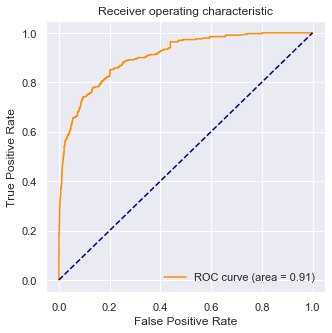

In [154]:
plt.figure(figsize=(5 , 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [155]:
### Unoptimized probability threshold based performance numbers
# Train accuracy numbers
trainPreds = np.where(model.predict_proba(train_proj)[:,1] > 0.5, 1, 0)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainF1score = f1_score(y_train, trainPreds)
trainResults=[train_proj.shape[0], 0.5, trainAccuracy, trainRecall, trainPrecision, trainF1score]
# Test accuracy numbers
testPreds = np.where(model.predict_proba(test_proj)[:,1] > 0.5, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[test_proj.shape[0], 0.5, testAccuracy, testRecall, testPrecision, testF1score]

In [156]:
optimalF1 = 0
optimalTh = 0
for th in thresholds:
    preds = np.where(model.predict_proba(train_proj)[:,1]>th,1,0)
    f1score = f1_score(y_train,preds)
    if(optimalF1<f1score):
        optimalF1 = f1score
        optimalTh = th

In [157]:
trainpreds = np.where(model.predict_proba(train_proj)[:,1]>optimalTh,1,0)
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
trainF1score = f1_score(y_train, trainpreds)
optimalTrainResults=[train_proj.shape[0], optimalTh, trainaccuracy, trainrecall, trainprecision, trainF1score]

In [158]:
# Optimal probability threshold based test accuracy numbers
testPreds = np.where(model.predict_proba(test_proj)[:,1] > optimalTh, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
optimalTestResults=[test_proj.shape[0], optimalTh, testAccuracy, testRecall, testPrecision, testF1score]

In [159]:
 # Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalTh", "accuracy", "recall", "precision", "f1_score"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults

In [160]:
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalTh,0.358043,0.358043,0.500000,0.500000
accuracy,0.936286,0.932667,0.935429,0.936000
recall,0.560606,0.526667,0.433333,0.426667
precision,0.703422,0.724771,0.785714,0.864865
f1_score,0.623946,0.610039,0.558594,0.571429


In [161]:
# Confusion matrix on the optimal threshold
print("The confusion matrix for the Logistic Regression model after optimatization is:")
metrics.confusion_matrix(y_test, testPreds)

The confusion matrix for the Logistic Regression model after optimatization is:


array([[1320,   30],
       [  71,   79]], dtype=int64)

## KNeighbors Model

In [162]:
KNN_model = KNeighborsClassifier()
KNN_model.fit(train_proj, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [163]:
print("Train accuracy: ", KNN_model.score(train_proj, y_train))
print("Test accuracy: ", KNN_model.score(test_proj, y_test))

Train accuracy:  0.9645714285714285
Test accuracy:  0.952


In [164]:
# Confusion matrix of the KNN model without optimal K
print("The confusion matrix for the KNN model without optimal k:")
metrics.confusion_matrix(y_test, KNN_model.predict(test_proj))

The confusion matrix for the KNN model without optimal k:


array([[1332,   18],
       [  54,   96]], dtype=int64)

In [165]:
trainPreds = KNN_model.predict(train_proj)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainResults=[train_proj.shape[0], 5, trainAccuracy, trainRecall, trainPrecision]

In [166]:
testPreds = KNN_model.predict(test_proj)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[test_proj.shape[0], 5, testAccuracy, testRecall, testPrecision]

In [167]:
# Finding the optimal K to find the best fit model

In [168]:
train_proj.shape[0]

3500

In [169]:
maxk = int(np.sqrt(train_proj.shape[0]))
maxk

59

In [170]:
optimalK = 1
optimalTrainAccuracy = 0

In [171]:
for k_i in range(maxk):
    if(((k_i%2)!=0)&(k_i>1)):
        KNN_model = KNeighborsClassifier(n_neighbors=k_i)
        KNN_model.fit(train_proj, y_train)
        if(KNN_model.score(train_proj, y_train)>optimalTrainAccuracy):
            optimalK = k_i
            optimalTrainAccuracy = KNN_model.score(train_proj, y_train)
print((optimalK, optimalTrainAccuracy))

(3, 0.9734285714285714)


In [172]:
KNN_model = KNeighborsClassifier(n_neighbors=3) # optimal k being 3
KNN_model.fit(train_proj, y_train)
KNN_model.score(train_proj, y_train)

0.9734285714285714

In [173]:
print("Train accuracy on optimal K: ", KNN_model.score(train_proj, y_train))
print("Test accuracy on optimal K: ", KNN_model.score(test_proj, y_test))

Train accuracy on optimal K:  0.9734285714285714
Test accuracy on optimal K:  0.9546666666666667


In [174]:
#Train data prediction and accurancy based on optimal k
trainpreds = KNN_model.predict(train_proj) 
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
optimalTrainResults=[train_proj.shape[0], optimalK, trainaccuracy, trainrecall, trainprecision]

In [175]:
#Test data prediction and accurancy based on optimal k
testPreds = KNN_model.predict(test_proj) 
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
optimalTestResults=[test_proj.shape[0], optimalK, testAccuracy, testRecall, testPrecision]

In [176]:
 # Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalK", "accuracy", "recall", "precision"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults

In [177]:
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalK,3.000000,3.000000,5.000000,5.000000
accuracy,0.973429,0.954667,0.964571,0.952000
recall,0.769697,0.660000,0.690909,0.640000
precision,0.937269,0.853448,0.912000,0.842105


In [178]:
# Confusion matrix of the KNN model with optimal K
print("The confusion matrix for the KNN model with optimal k:")
metrics.confusion_matrix(y_test, KNN_model.predict(test_proj))

# Recall has improved with the optimalk and the accuracy has also gone up.
#There is a bit of decrease in the precision.

The confusion matrix for the KNN model with optimal k:


array([[1333,   17],
       [  51,   99]], dtype=int64)

In [179]:
# Recall of the KNN model with optimal K is much better than the Logistic Regression model

## Naive Bayes Model

In [180]:
# We will now use build our model on Naive Bayes Algorithm

In [181]:
NB_model = GaussianNB()
NB_model.fit(train_proj, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [182]:
test_predict = NB_model.predict(test_proj)
test_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [183]:
print("Gaussian Naive Bayes Model Score on train data: ", NB_model.score(train_proj, y_train))
print("Gaussian Naive Bayes Model Score on test data: ", NB_model.score(test_proj, y_test))

Gaussian Naive Bayes Model Score on train data:  0.9077142857142857
Gaussian Naive Bayes Model Score on test data:  0.9106666666666666


In [184]:
# Confusion Matrix for Naive Bayes Model without any optimization
print("Confusion matrix for Naive Bayes without any optimization:\n")
metrics.confusion_matrix(y_test,test_predict)

Confusion matrix for Naive Bayes without any optimization:



array([[1297,   53],
       [  81,   69]], dtype=int64)

In [185]:
# From below confusion matrix, we can make below inferences:
# True Positives (TP): we correctly predicted 1297 people won't be opting for a personal loan
# True Negatives (TN): we correctly predicted 69 people will opt for a loan
# False Positives (FP): we incorrectly predicted that 53 people would be taking a loan (a "Type I error")53 Falsely predict positive Type I error
# False Negatives (FN): we incorrectly predicted that 81 people wouldn't opt for a loan (a "Type II error") 81 Falsely predict negative Type II error

In [186]:
pd.DataFrame(data=[accuracy_score(y_test, test_predict), 
                   recall_score(y_test, test_predict), 
                   precision_score(y_test, test_predict),
                   f1_score(y_test, test_predict)], 
             index=["accuracy", "recall", "precision", "f1_score"])

,0
accuracy,0.910667
recall,0.460000
precision,0.565574
f1_score,0.507353


In [187]:
# We have to do some optimization to increase our recall score

In [188]:
y_predictprob = NB_model.predict_proba(train_proj)
y_predictprob
#Column 1 is the probability that customer doesn't opt for loan
#Column 2 is the probability that customer opts for a loan

array([[0.9975966 , 0.0024034 ],
       [0.99864429, 0.00135571],
       [0.99703589, 0.00296411],
       ...,
       [0.99714219, 0.00285781],
       [0.9885937 , 0.0114063 ],
       [0.9977885 , 0.0022115 ]])

In [189]:
np.where(NB_model.predict_proba(train_proj)[:,1]>0.5,1,0)[0:10]
# Currently we require only the customers who would take up the loan, so using the 2nd column [:,1]
# 0.5 is the default threshold we taken, we need to identify the optimal threshold

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [190]:
fpr, tpr, thresholds = roc_curve(y_train, y_predictprob[::,1])

In [191]:
thresholds

array([1.99996623e+00, 9.99966226e-01, 9.99955386e-01, 9.99857980e-01,
       9.99491226e-01, 9.99417764e-01, 9.98954855e-01, 9.98927829e-01,
       9.98895560e-01, 9.98849621e-01, 9.98436595e-01, 9.98402117e-01,
       9.98050498e-01, 9.97954573e-01, 9.96895806e-01, 9.96837477e-01,
       9.96700861e-01, 9.96588743e-01, 9.95588074e-01, 9.95349689e-01,
       9.95009432e-01, 9.94682455e-01, 9.94282032e-01, 9.94251506e-01,
       9.92111473e-01, 9.90283130e-01, 9.90251455e-01, 9.89990242e-01,
       9.89927732e-01, 9.88813018e-01, 9.88673541e-01, 9.88351519e-01,
       9.88230794e-01, 9.88012039e-01, 9.87727508e-01, 9.87450687e-01,
       9.87375455e-01, 9.86687888e-01, 9.83991220e-01, 9.83936864e-01,
       9.83616266e-01, 9.83339743e-01, 9.82547445e-01, 9.81044095e-01,
       9.80009853e-01, 9.77938471e-01, 9.75624725e-01, 9.75023653e-01,
       9.74843307e-01, 9.74609179e-01, 9.70986610e-01, 9.70892838e-01,
       9.70226435e-01, 9.70162351e-01, 9.69809707e-01, 9.69007885e-01,
      

In [192]:
roc_auc = auc(fpr,tpr)
roc_auc

0.8858369180766656

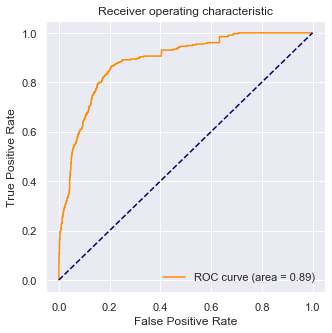

In [193]:
plt.figure(figsize=(5 , 5))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [194]:
### Unoptimized probability threshold based performance numbers
# Train accuracy numbers
trainPreds = np.where(NB_model.predict_proba(train_proj)[:,1] > 0.5, 1, 0)
trainAccuracy = accuracy_score(y_train, trainPreds)
trainRecall = recall_score(y_train, trainPreds)
trainPrecision = precision_score(y_train, trainPreds)
trainF1score = f1_score(y_train, trainPreds)
trainResults=[train_proj.shape[0], 0.5, trainAccuracy, trainRecall, trainPrecision, trainF1score]
# Test accuracy numbers
testPreds = np.where(NB_model.predict_proba(test_proj)[:,1] > 0.5, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
testResults=[test_proj.shape[0], 0.5, testAccuracy, testRecall, testPrecision, testF1score]

In [195]:
optimalF1 = 0
optimalTh = 0
for th in thresholds:
    preds = np.where(NB_model.predict_proba(train_proj)[:,1]>th,1,0)
    f1score = f1_score(y_train,preds)
    if(optimalF1<f1score):
        optimalF1 = f1score
        optimalTh = th

In [196]:
trainpreds = np.where(NB_model.predict_proba(train_proj)[:,1]>optimalTh,1,0)
trainaccuracy = accuracy_score(y_train, trainpreds)
trainrecall = recall_score(y_train, trainpreds)
trainprecision = precision_score(y_train, trainpreds)
trainF1score = f1_score(y_train, trainpreds)
optimalTrainResults=[train_proj.shape[0], optimalTh, trainaccuracy, trainrecall, trainprecision, trainF1score]

In [197]:
# Optimal probability threshold based test accuracy numbers
testPreds = np.where(NB_model.predict_proba(test_proj)[:,1] > optimalTh, 1, 0)
testAccuracy = accuracy_score(y_test, testPreds)
testRecall = recall_score(y_test, testPreds)
testPrecision = precision_score(y_test, testPreds)
testF1score = f1_score(y_test, testPreds)
optimalTestResults=[test_proj.shape[0], optimalTh, testAccuracy, testRecall, testPrecision, testF1score]

In [198]:
# Concatenate Train and Test results to resultsDf
resultsDf = pd.DataFrame( index=["dataSize", "optimalTh", "accuracy", "recall", "precision", "f1_score"])
resultsDf['optimalTrainResults'] = optimalTrainResults
resultsDf['optimalTestResults'] = optimalTestResults
resultsDf['unOptimalTrainResults'] = trainResults
resultsDf['unOptimalTestResults'] = testResults

In [199]:
resultsDf

,optimalTrainResults,optimalTestResults,unOptimalTrainResults,unOptimalTestResults
dataSize,3500.000000,1500.000000,3500.000000,1500.000000
optimalTh,0.426631,0.426631,0.500000,0.500000
accuracy,0.906000,0.906000,0.907714,0.910667
recall,0.530303,0.493333,0.500000,0.460000
precision,0.501433,0.532374,0.510836,0.565574
f1_score,0.515464,0.512111,0.505360,0.507353


In [200]:
# Confusion matrix for Naive Bayes Model on the optimal threshold
print("The confusion matrix for the Naive Bayes model after optimatization is:")
metrics.confusion_matrix(y_test, testPreds)

The confusion matrix for the Naive Bayes model after optimatization is:


array([[1285,   65],
       [  76,   74]], dtype=int64)

### In this case study,we want to predict correctly the customers who might take up the loan, i.e., recall needs to be high. Even if precision is low, it won't impact much to the management but recall can't be low.
####  Maximum features for prediction:                                                                                                                             The best model is Logistic Regression model with optimization in threshold.
#### Only Colinear features used for prediction:                                                                                                                  If we look for high accuracy and according a better recall then KNN should be a preffered model.                              If we take a bit of hit on accuracy and go for much better recall then Naive Bayes is the best model to opt for.
#### We will place this results in front of domain expert and management, based on their requirement they can opt for one of the solution
### As per my analysis, Naive Bayes will be best model where features that are colinear with target are taken for prediction. As it gives the high recall and it will help the in predicting more number of potential customers correctly.

In [201]:
print("Maximum features used for prediction:")
pd.DataFrame(data=["Accuracy 92%, Recall 50, Precision 64", 
                   "Accuracy 92%, Recall 44, Precision 75", 
                   "Accuracy 90%, Recall 44, Precision 54"],
             index=["Logistic Regression", "KNN", "Naive Bayes"])

Maximum features used for prediction:


,0
Logistic Regression,"Accuracy 92%, Recall 50, Precision 64"
KNN,"Accuracy 92%, Recall 44, Precision 75"
Naive Bayes,"Accuracy 90%, Recall 44, Precision 54"


In [202]:
print("Only colinear features used:")
pd.DataFrame(data=["Accuracy 93%, Recall 52, Precision 72", 
                   "Accuracy 95%, Recall 66, Precision 85", 
                   "Accuracy 88%, Recall 75, Precision 45"],
             index=["Logistic Regression", "KNN", "Naive Bayes"])

Only colinear features used:


,0
Logistic Regression,"Accuracy 93%, Recall 52, Precision 72"
KNN,"Accuracy 95%, Recall 66, Precision 85"
Naive Bayes,"Accuracy 88%, Recall 75, Precision 45"


In [203]:
print("Only colinear features used: (With PCA)")
pd.DataFrame(data=["Accuracy 93%, Recall 52, Precision 72", 
                   "Accuracy 95%, Recall 66, Precision 85", 
                   "Accuracy 90%, Recall 49, Precision 53"],
             index=["Logistic Regression", "KNN", "Naive Bayes"])

Only colinear features used: (With PCA)


,0
Logistic Regression,"Accuracy 93%, Recall 52, Precision 72"
KNN,"Accuracy 95%, Recall 66, Precision 85"
Naive Bayes,"Accuracy 90%, Recall 49, Precision 53"


#### PCA in this case study doesn't help much, so won't be presenting it to the management